In [36]:
library(dplyr)
library(stringr)
library(textdata)
library(tidytext)
library(ggplot2)
library(gridExtra)
library(tm)

In [5]:
setwd("/Users/trishasharma/Desktop/")
df <- read.csv("Airline-Sentiment-2-w-AA.csv")
print(head(df))
doc<-Corpus(VectorSource(df))

  X_unit_id X_golden X_unit_state X_trusted_judgments X_last_judgment_at
1 681448150    FALSE    finalized                   3       2/25/15 5:24
2 681448153    FALSE    finalized                   3       2/25/15 1:53
3 681448156    FALSE    finalized                   3      2/25/15 10:01
4 681448158    FALSE    finalized                   3       2/25/15 3:05
5 681448159    FALSE    finalized                   3       2/25/15 5:50
6 681448162    FALSE    finalized                   3       2/25/15 9:10
  airline_sentiment airline_sentiment.confidence negativereason
1           neutral                       1.0000               
2          positive                       0.3486               
3           neutral                       0.6837               
4          negative                       1.0000     Bad Flight
5          negative                       1.0000     Can't Tell
6          negative                       1.0000     Can't Tell
  negativereason.confidence        airlin

In [45]:
suppressWarnings({
  doc <- tm_map(doc, content_transformer(tolower))#convert all text to lower case
  doc <- tm_map(doc, removeNumbers)#Remove numbers from doc
  doc <- tm_map(doc, removeWords, stopwords("english"))#remove stopwords in English
  doc <- tm_map(doc, removePunctuation, preserve_intra_word_dashes = TRUE)
  doc <- tm_map(doc, stripWhitespace)#remove white spaces
})

In [51]:
dtm<-DocumentTermMatrix(doc)
airline <- tidy(dtm)
airline

document,term,count
<chr>,<chr>,<dbl>
2,cfalse,1
2,false,14599
2,true,40
3,cfinalized,1
3,finalized,14582
3,golden,40
3,progress,17
6,cneutral,1
6,negative,9178


In [49]:
head(get_sentiments("afinn")) #retrieve the affin lexicon which scores words from -5 to 5 
head(get_sentiments("bing"))#classify at words as positive or negative 
head(get_sentiments("nrc"))#classify words as sadness, anger, fear etc

word,value
<chr>,<dbl>
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
abductions,-2


word,sentiment
<chr>,<chr>
2-faces,negative
abnormal,negative
abolish,negative
abominable,negative
abominably,negative
abominate,negative


word,sentiment
<chr>,<chr>
abacus,trust
abandon,fear
abandon,negative
abandon,sadness
abandoned,anger
abandoned,fear


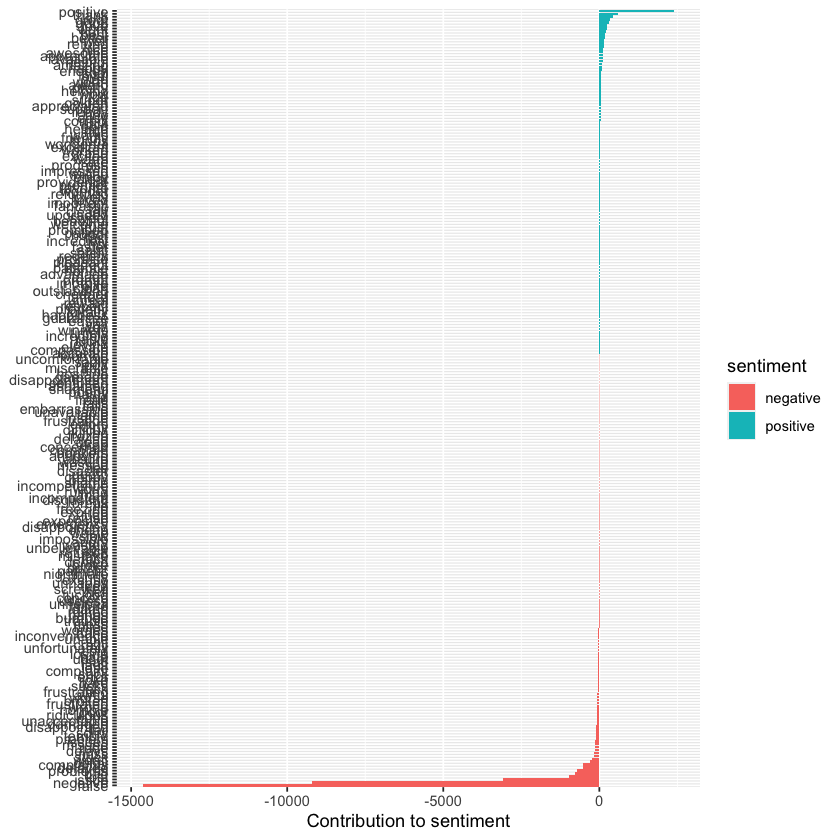

In [20]:
airline_sentiment<- airline %>%
  inner_join(get_sentiments("bing"), by = c(term = "word"))
airline_sentiment %>%
  count(sentiment, term, wt = count) %>%
  ungroup() %>%
  filter(n >= 10) %>%
  mutate(n = ifelse(sentiment == "negative", -n, n)) %>%
  mutate(term = reorder(term, n)) %>%
  ggplot(aes(n, term, fill = sentiment)) +
  geom_col() +
  labs(x = "Contribution to sentiment", y = NULL)

In [22]:
nrc_word_counts <-airline%>%
  inner_join(get_sentiments("nrc"), by = c(term = "word"), relationship = "many-to-many") %>%
  count(term, sentiment, sort = TRUE) %>%
  ungroup()

print(nrc_word_counts)

# A tibble: 3,811 × 3
   term      sentiment     n
   <chr>     <chr>     <int>
 1 bad       anger         4
 2 bad       disgust       4
 3 bad       fear          4
 4 bad       negative      4
 5 bad       sadness       4
 6 late      negative      4
 7 late      sadness       4
 8 lost      negative      4
 9 lost      sadness       4
10 attendant positive      3
# ℹ 3,801 more rows


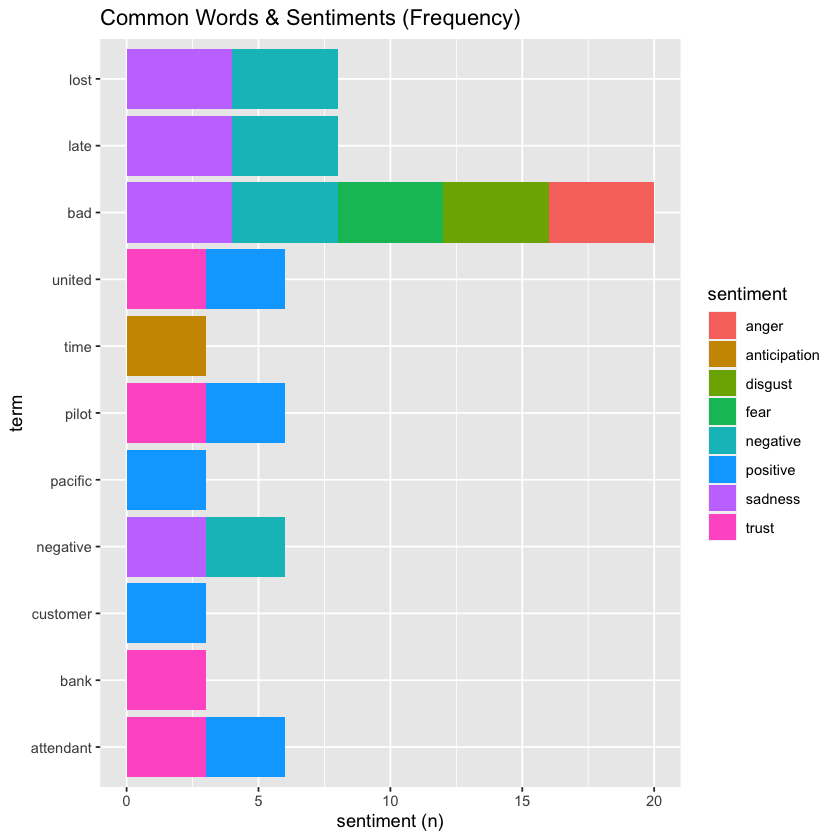

In [24]:
nrc_word_counts %>%
  filter(n > 2) %>%
  mutate(term = reorder(term, n)) %>%
  ggplot(aes(term, n, fill = sentiment)) +
  geom_col() +
  coord_flip() +
  labs(y = "sentiment (n)") +
  ggtitle("Common Words & Sentiments (Frequency)")

Joining with `by = join_by(sentiment)`


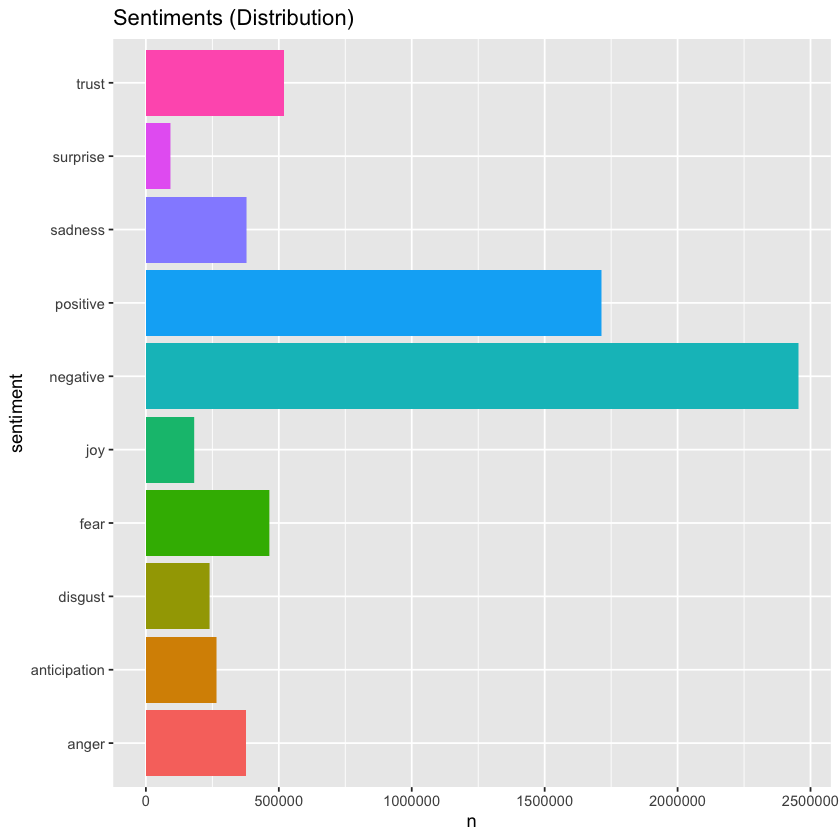

In [28]:
nrc_word_counts %>%
  inner_join(get_sentiments("nrc"),relationship = "many-to-many") %>%
  count(word, sentiment) %>%
  ggplot(aes(sentiment, n, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  ggtitle("Sentiments (Distribution)") +
  coord_flip()

In [53]:
bing_word_counts <- bind_rows(
  airline %>%
    inner_join(get_sentiments("bing"),by = c(term = "word"), relationship = "many-to-many") %>%
    mutate(method = "Bing"))
bing_word_counts

document,term,count,sentiment,method
<chr>,<chr>,<dbl>,<chr>,<chr>
2,false,14599,negative,Bing
3,golden,40,positive,Bing
3,progress,17,positive,Bing
6,negative,9178,negative,Bing
6,positive,2363,positive,Bing
8,bad,580,negative,Bing
8,complaints,481,negative,Bing
8,damaged,74,negative,Bing
8,issue,2910,negative,Bing


In [32]:
bing_word_counts <- bing_word_counts %>%
  mutate(sentiment_sum = ifelse(sentiment == "positive", 1, -1))
sentiment_sum_df <- bing_word_counts %>%
  select(document, sentiment_sum)
sentiment_sum_df$document <- as.character(sentiment_sum_df$document)
sentiment_sum_aggregated <- aggregate(sentiment_sum_df$sentiment_sum,
  by = list(line = sentiment_sum_df$document), FUN = sum)
colnames(sentiment_sum_aggregated) <- c('line', 'sentiment_sum')
sentiment_sum_aggregated

line,sentiment_sum
<chr>,<dbl>
11,0
12,3
13,-4
15,-372
19,4
2,-1
3,2
6,0
8,-6


  line sentiment_sum
1   11             0
2   12             3
3   13            -4
4   15          -372
5   19             4
6    2            -1
'data.frame':	9 obs. of  2 variables:
 $ line         : num  11 12 13 15 19 2 3 6 8
 $ sentiment_sum: num  0 3 -4 -372 4 -1 2 0 -6


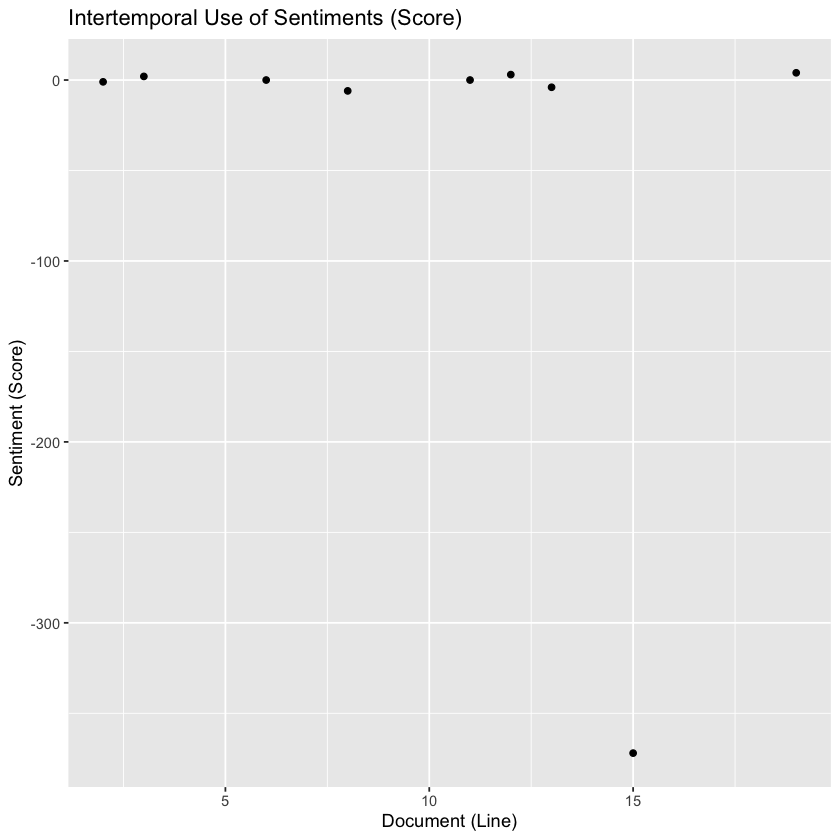

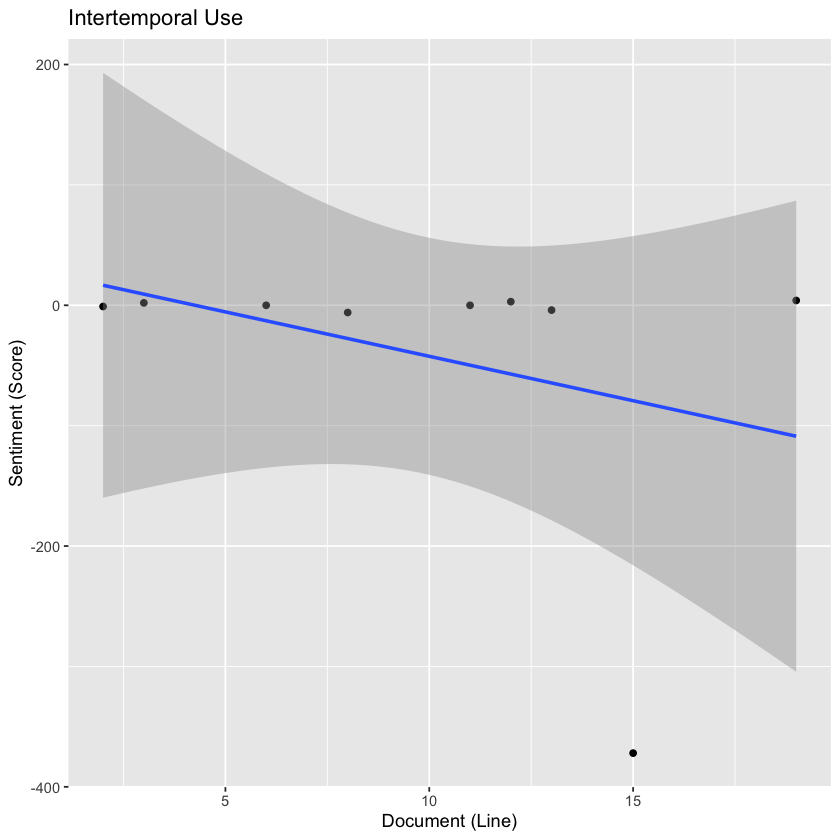

In [34]:
sentiment_sum_aggregated$line <- as.numeric(sentiment_sum_aggregated$line)
print(head(sentiment_sum_aggregated))
str(sentiment_sum_aggregated)
ggplot(data = sentiment_sum_aggregated, mapping = aes(x = line, y = sentiment_sum)) +
  geom_point() +
  xlab("Document (Line)") +
  ylab("Sentiment (Score)") +
  ggtitle("Intertemporal Use of Sentiments (Score)")

# Linear Model smoothing
ggplot(data = sentiment_sum_aggregated, mapping = aes(x = line, y = sentiment_sum)) +
  geom_point() +
  geom_smooth(method = "lm", formula = y ~ x) +
  xlab("Document (Line)") +
  ylab("Sentiment (Score)") +
  ggtitle("Intertemporal Use ")